## Diffusion Tensor Imaging (DTI)

Diffusion tensor imaging or "DTI" refers to images describing diffusion as a tensor model and is derived from preprocessed DWI data. First proposed by Basser and colleagues ([Basser, 1994](https://www.ncbi.nlm.nih.gov/pubmed/8130344)), the diffusion tensor model describes the diffusion within a voxel. This model has been very influential in demonstrating the utility of diffusion MRI in characterizing the microstructure of white matter and the biophysical properties (inferred from local diffusion properties). DTI is still a commonly used.

The diffusion tensor models the diffusion signal as:

$\frac{S(\mathbf{g}, b)}{S_0} = e^{-b\mathbf{g}^T \mathbf{D} \mathbf{g}}$

Where $\mathbf{g}$ is a unit vector in 3D space indicating the direction of measurement and b are the parameters of measurement, such as the strength and duration of diffusion-weighting gradient. $S(\mathbf{g}, b)$ is the diffusion-weighted signal measured and $S_0$ is the signal conducted in a measurement with no diffusion weighting. $\mathbf{D}$ is a positive-definite quadratic form, which contains six free parameters to be fit. These six parameters are:

$\mathbf{D} = \begin{pmatrix} D_{xx} & D_{xy} & D_{xz} \\
                              D_{yx} & D_{yy} & D_{yz} \\
                              D_{zx} & D_{zy} & D_{zz} \\ 
              \end{pmatrix}$

This matrix is a variance/covariance matrix of the diffusivity along the three spatial dimensions. Note that we can assume that diffusivity has antipodal symmetry, so elements across the diagonal are equal. For example: $D_{xy} = D_{yx}$. This is why there are only 6 free parameters to estimate here. 

Tensors are represented by ellipsoids characterized by calculated eigenvalues ($\lambda_1, \lambda_2, \lambda_3$) and eigenvectors ($\epsilon_1, \epsilon_2, \epsilon_3$) from the previously described matrix. Eigenvalues and eigenvectors are normally sorted in descending magnitude.

_**INSERT TENSOR IMAGE HERE**_

In the following example, we show how to model your diffusion datasets. It should be noted that there are a number of diffusion models and many of these are implemented in `Dipy`. However, for the purposes of this tutorial, we will be focus on the tensor model.

### Reconstruction with the `dipy.reconst` module

The `reconst` module contains implementations of the following models: 

- Tensor (Basser et al., 1994)
- Constrained Spherical Deconvolution (Tournier et al. 2007)
- Diffusion Kurtosis (Jensen et al. 2005)
- DSI (Wedeen et al. 2008)
- DSI with deconvolution (Canales-Rodriguez et al. 2010)
- Generalized Q Imaging (Yeh et al. 2010)
- MAPMRI (Ozarsalan et al. 2013)
- SHORE (Ozarsalan et al. 2008)
- CSA (Aganj et al. 2009)
- Q ball (Descoteaux et al. 2007)
- OPDT (Tristan-Vega et al. 2010)
- Sparse Fascicle Model (Rokem et al. 2015)

The different algorithms implemented in the `reconst` module all share a similar conceptual structure: 

- `ReconstModel` objects (e.g, `TensorModel`) carry the parameters that are required in order to fit a model. For example, the directions and intensities of the gradients that were applied in the experiment. The all have a `fit` method, which takes in data, and emits a `ReconstFit` object. This is where a lot of the heavy lifting will take place.
- `ReconstFit` objects carry the model that was used to generate them. They also carry around the parameters that were estimated during fitting of the data. They have methods to calculate derived statistics, such as FA and MD (for the tensor), which can differ from module to module. The also all have an `odf` , and most of them (but not all) have `predict` methods, which allow you to predict another data-set based on the a gradient table.

### Reconstruction with the Tensor (dti) model

Let's get started! First, we will need to grab **pre-processed** dwi files and load them! We will also load in the anatomical image to use as a reference later on! 

In [1]:
from bids.layout import BIDSLayout
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from nilearn import image as img
import nibabel as nib

layout = BIDSLayout("../data/ds000030/derivatives", validate=False)

t1 = layout.get(subject='10788', suffix='T1w', extension='nii.gz', return_type='file')[0]
dwi = layout.get(subject='10788', suffix='preproc', extension='nii.gz', return_type='file')[0]
bval = layout.get(subject='10788', suffix='preproc', extension='bval', return_type='file')[0]
bvec = layout.get(subject='10788', suffix='preproc', extension='bvec', return_type='file')[0]

t1_data = img.load_img(t1)
dwi_data = img.load_img(dwi)

gt_bvals, gt_bvecs = read_bvals_bvecs(bval, bvec)
gtab = gradient_table(gt_bvals, gt_bvecs)

/home/tkai/.venv/dti_venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Next, we need to create the "tensor model using our gradient table and then fit the model using our data! We will start by creating a mask from our data and apply it to avoid calculating tensors on the background! This can be done using dipy's mask module. Then, we will our data!

In [2]:
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu

dwi_data = dwi_data.get_data() # We re-use the variable for memory purposes 
dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1) # Specify the volume index to the b0 volumes

dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi_data, mask=dwi_mask) # This step may take a while

The fit method creates a TensorFit object which contains the fitting parameters and other attributes of the model. A number of quantitative scalar metrics can be computed using these eigenvalues. In this tutorial we will cover fractional anisotropy, mean diffusivity, axial diffusivity and radial diffusivity! Each of these scalar metrics were calculated in the previous fitting step!

### Fractional anisotropy (FA)
**Fractional anisotropy (FA)** characterizes the degree to which the distribution of diffusion in a voxel is directional. That is, whether there is relatively unrestricted diffusion in one particular direction.

Mathematically, FA is defined as the normalized variance of the eigenvalues of the tensor: 

$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                   \lambda_2^2+\lambda_3^2}}$
                   
Values of FA vary between 0 and 1. In the cases of perfect, isotropic diffusion, $\lambda_1 = \lambda_2 = \lambda_3$, the diffusion ellipsoid is a sphere and FA = 0. As diffusion progressively becomes more aniostropic, eigenvalues become more unequal causing the ellipsoid to be elongated, with FA &rarr; 1. Note that FA should be interpreted carefully. It may be an indication of the density of packing of fibers in a voxel, and the amount of myelin wrapping these axons, but it is not always a measure of "tissue integrity".

Lets take a look at what the FA map looks like! A FA map is a gray-scale, where brighter areas reflect more anisotropic regions.

_Note: We will have to first create the image from the array (hint: use the reference anatomical)_

In [3]:
import matplotlib.pyplot as plt # To enable plotting within notebook
from nilearn import plotting as plot

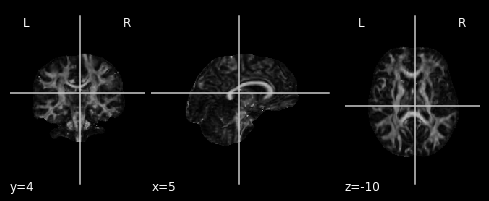

In [4]:
%matplotlib inline 

fa_img = img.new_img_like(ref_niimg=t1_data, data=dti_fit.fa)
plot.plot_anat(fa_img)

### Mean diffusivity (MD)
An often used complimentary measure to FA is **mean diffusivity (MD)**. MD is a measure of the degree of diffusion, independent of direction. This is sometimes known as the **apparent diffusion coefficient (ADC)**. Mathematically, MD is computed as the mean eigenvalues of the tensor.

$MD = \frac{\lambda_1 + \lambda_2 + \lambda_3}{3}$ 
                   
Lets take a look at what the MD map looks like! Brighter areas reflect higher diffusivity!.

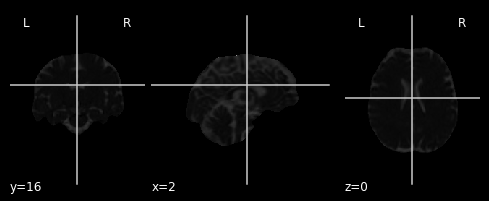

In [5]:
%matplotlib inline 

md_img = img.new_img_like(ref_niimg=t1_data, data=dti_fit.md)
plot.plot_anat(md_img)

### Axial Diffusivity (AD)
**Axial diffusivity (AD)** describes the diffusion rate along the primary axis of diffusion - along $\lambda_1$, or parallel to the axon.

$AD = \lambda_1$

Try plotting the image!

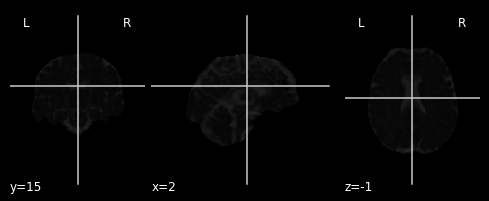

In [6]:
%matplotlib inline 

ad_img = img.new_img_like(ref_niimg=t1_data, data=dti_fit.ad)
plot.plot_anat(ad_img)

### Radial Diffusivity (RD)

The final metric we will discuss is **radial diffusivity (RD)**. This metric reflects the average diffusivity along the two minor axes ($\lambda_2, \lambda_3$).

$RD = \frac{\lambda_2 + \lambda_3}{2}$

Again, try plotting the RD map!

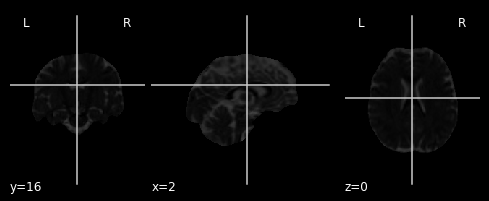

In [7]:
%matplotlib inline 

rd_img = img.new_img_like(ref_niimg=t1_data, data=dti_fit.rd)
plot.plot_anat(rd_img)

### Tensor visualizations
There are several ways of visualizing tensors. One way is using an RGB map based on the primary diffusion direction ($\lambda_1$) overlayed on the FA map, where the colour encodes the direction of diffusion! To do this with dipy, we can use the `color_fa` function. The colors map to the following directions:

* Red = Left/Right
* Green = Anterior/Posterior
* Blue = Superior/Inferior

_Note: `nilearn`'s plotting functions are unable to visualize these RGB maps. However, we can use Python's `matplotlib` to view these images._

In [8]:
from dipy.reconst.dti import color_fa
RGB_map = color_fa(dti_fit.fa, dti_fit.evecs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


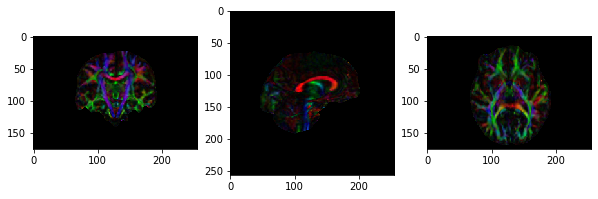

In [9]:
%matplotlib inline 

from scipy import ndimage # To rotate image for visualization purposes

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(ndimage.rotate(RGB_map[:, RGB_map.shape[1]//2, :, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(RGB_map[RGB_map.shape[0]//2, :, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(RGB_map[:, :, RGB_map.shape[2]//2, :], 90, reshape=False))

Another way of viewing the tensors is to visualize the diffusion tensor in each imaging voxel with colour encoding (we will refer you to the [`Dipy` documentation](https://dipy.org/tutorials/) for the steps to perform this type of visualization as it can be memory intensive). Below is an example image of such tensor visualization.

![Tensor Visualization](images/TensorViz.png)

### Some notes on DTI

DTI is only one of many models and is one of the simplest models available for modelling diffusion. While it is used for many studies, there are also some drawbacks (eg. ability to distinguish multiple fibre orientations in one imaging voxel). Some examples can be seen below! 

![fiber_configurations](images/FiberConfigurations.png)

Sourced from: Sotiropolous and Zalewsky. (2017). Building connectomes using diffusion MRI: why, how, and but. NMR in Biomedicine. 4(32). e3752. 10.1002/nbm.3752. 

Though other models are outside the scope of this lesson, we recommend looking into some of the pros and cons of each model (listed previously) to choose one best suited for your data! 